In [1]:
BACKEND = "torch" # 13 to go for 2**14 torch
NUM_WARMUP = 2**10
NUM_SAMPLES = 2**14
NUM_CHAINS = 1
NUM_REPS = 20
JIT = False  # Does not seem to have a big impact on the speed in my case.

fname = "result_{}_{}_{}_{}_{}.pkl".format(
    BACKEND,
    NUM_WARMUP,
    NUM_SAMPLES,
    NUM_CHAINS,
    NUM_REPS
)
if JIT:
    fname = "jit_" + fname
print(fname)

%load_ext autoreload
%autoreload 2
%matplotlib agg

if BACKEND == "torch":
    import pyro as pyro
    from pyro import distributions as dist
    from pyro.infer import MCMC, NUTS
elif BACKEND=="jax":
    import numpyro as pyro
    from numpyro import distributions as dist
    from numpyro.infer import MCMC, NUTS
    pyro.set_platform("cpu")
    pyro.set_host_device_count(NUM_CHAINS)
else:
    pass

import pickle
import time
import visualization
from data import datasets

import torch
import numpy as np
import jax
import jax.numpy as jnp

rng_key = jax.random.PRNGKey(0)
print(jax.local_device_count())

result_torch_1024_16384_1_20.pkl


1


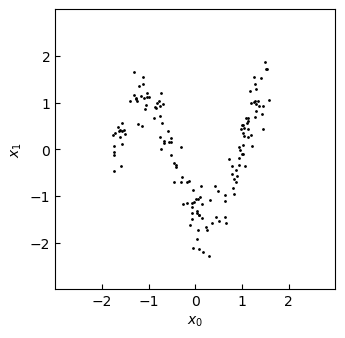

In [2]:
rng_key, rng_key_ = jax.random.split(rng_key)
dataset = datasets.Sinusoidal(normalization="standardization", rng_key=rng_key_)
X_train, y_train = dataset[:]

if BACKEND == "torch":
    X_train = torch.from_numpy(np.array(X_train))
    y_train = torch.from_numpy(np.array(y_train))

figure = visualization.TriangleFigure(
    prefix="x", ax_width=4, ax_height=4,
    settings=visualization.TriangleSettings(univariate=False)
)
figure.plot(data=dataset.data)

In [3]:
class NN:
    def __init__(self):
        pass
    
    def forward(self, parameters, inputs):
        j = 0
        layers=[1, 2, 1]
        for i in range(len(layers) - 1):
            j_new = j + (layers[i] + 1) * layers[i + 1]
            weight = parameters[j:j_new - layers[i + 1]].reshape((layers[i + 1], layers[i]))
            bias = parameters[j_new - layers[i + 1]:j_new].reshape((layers[i + 1]))
            j = j_new
            
            # apply transformations
            if BACKEND == "jax":
                inputs = jnp.add(jnp.matmul(inputs, weight.T), bias)
                if i < (len(layers) - 2):
                    inputs = jnp.tanh(inputs)
            elif BACKEND == "torch":
                inputs = torch.add(torch.matmul(inputs, weight.T), bias)
                if i < (len(layers) - 2):
                    inputs = torch.tanh(inputs)
            else:
                continue
        
        return inputs

In [4]:
def model(fn, X, y):
    parameters_size = 7 #sum(map(lambda i: (layers[i] + 1) * layers[i + 1], range(len(layers) - 1)))
    if BACKEND == "torch":
        w = pyro.sample("w", dist.Normal(torch.zeros(parameters_size), torch.ones(parameters_size)))
    elif BACKEND == "jax":
        w = pyro.sample("w", dist.Normal(jnp.zeros(parameters_size), jnp.ones(parameters_size)))
    else:
        pass
    
    outputs = fn(parameters=w, inputs=X)
    logstd_ll = pyro.sample("logstd_ll", dist.Normal(0.0, 1.0))  # TODO: Try LogNormal
    
    if BACKEND == "torch":
        std_ll = torch.exp(logstd_ll)
    elif BACKEND == "jax":
        std_ll = jnp.exp(logstd_ll)
    else:
        pass
    
    # observe data
    with pyro.plate("data", size=X.shape[0], dim=-2):
        return pyro.sample("outputs", dist.Normal(outputs, std_ll), obs=y)

In [5]:
def infer(rng_key, num_warmup, num_samples, num_chains, model, nn, X, y):
    start = time.time()
    
    if BACKEND == "torch":
        kernel = NUTS(model, jit_compile=JIT)
        mcmc = MCMC(kernel, warmup_steps=num_warmup, num_samples=num_samples, num_chains=num_chains,)
        mcmc.run(nn, X_train, y_train)
    elif BACKEND == "jax":
        kernel = NUTS(model)
        mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains,
                    #chain_method="parallel",
                    #jit_model_args=True,
                    progress_bar=True
                   )
        mcmc.run(rng_key, nn, X_train, y_train)
    else:
        pass
    
    time_difference = time.time() - start
    print("\nMCMC elapsed time:", time_difference)
    return mcmc, time_difference

In [ ]:
samples_per_chain = int(1.0 * NUM_SAMPLES / NUM_CHAINS)
result = {
    "num_warmup": NUM_WARMUP,
    "num_chains": NUM_CHAINS,
    "samples_per_chain": samples_per_chain,
    "times": [],
    "samples": []
}

for i in range(NUM_REPS):
    result = pickle.load(open("output/{}".format(fname), "rb"))
    rng_key, rng_key_ = jax.random.split(rng_key)
    nn = NN()
    mcmc, time_difference = infer(
        rng_key=rng_key_,
        num_warmup=NUM_WARMUP,
        num_samples=samples_per_chain,
        num_chains=NUM_CHAINS,
        model=model,
        nn=nn.forward,
        X=X_train,
        y=y_train
    )
    samples = mcmc.get_samples()
    result["times"].append(time_difference)
    result["samples"].append(samples)
    pickle.dump(result, open("output/{}".format(fname), "wb"))

In [14]:
pickle.dump(result, open("output/{}".format(fname), "wb"))

In [ ]:
ws_original = result["samples"][0]["w"]
logstds = result["samples"][0]["logstd_ll"]
if BACKEND == "torch":
    ws_original = jnp.array(ws_original.numpy())
    logstds = jnp.array(logstds.numpy())
ws = jax.random.permutation(rng_key, ws_original)
logstds_mean = jnp.mean(logstds)

In [ ]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.1),
        univariate=False
    )
)
figure.plot(data=ws[:4096])

In [ ]:
#regression_figure = visualization.RegressionFigure(width=4, height=4)
#regression_figure.plot(data=jnp.stack([np.array(X_train), np.array(y_train)], axis=-1), transformation=NN().forward, parameters=ws[:1024], logstd=logstds_mean)

In [ ]:
# TODO: CHECK THIS: https://jax.readthedocs.io/en/latest/profiling.html